# Control analysis across the population 

In [1]:
# Load the tfa model 
from pytfa.io.json import load_json_model
model_file = 'reduced_model_ETC_core_20240710-100629_continuous.json'
tmodel = load_json_model(model_file)
#sol = tmodel.optimize()

2024-07-22 16:28:18,307 - thermomodel_Recon3thermoCurated - continuous - INFO - # Model initialized with units kcal/mol and temperature 298.15 K


In [2]:
# Reload and prepare the model
from skimpy.io.yaml import load_yaml_model
from skimpy.utils.tabdict import TabDict

kmodel = load_yaml_model(model_file.replace("_continuous.json", "_kinetic_curated.yml"))

# We calculate control coeffcients with respect
#  to enzyme activity and boundary concentrations
parameter_list = TabDict([(k, p.symbol) for k, p in kmodel.parameters.items() if p.name.startswith('vmax_forward')])
boundary_parameters = TabDict([(c.reactant.name, c.reactant.symbol) for c in kmodel.boundary_conditions.values()])
parameter_list.update(boundary_parameters)

# Compile the jacobian expressions
NCPU = 12
kmodel.prepare()
kmodel.compile_mca(ncpu=NCPU, parameter_list=parameter_list)

In [ ]:
# Load TFA samples 
import pandas as pd
tfa_sample_file = 'reduced_model_ETC_core_20240710-100629_tfa_sampling.csv'
tfa_samples = pd.read_csv(tfa_sample_file)

In [ ]:
# Load parameter samples 
from skimpy.core.parameters import load_parameter_population
parameter_population = load_parameter_population(tfa_sample_file.replace(".csv",'_pruned_parameters.hdf5'))

In [ ]:
# Scaling parameters
CONCENTRATION_SCALING = 1e3 # 1 mol to 1 umol
TIME_SCALING = 1 # 1min
DENSITY = 1200 # g/L 
GDW_GWW_RATIO = 1.0 # Fluxes are in gWW

In [ ]:
from skimpy.analysis.oracle.load_pytfa_solution import load_fluxes, load_concentrations,\
    load_equilibrium_constants
import numpy as np

flux_controll_coefficients = []
parameter_sample_ids = []

for k in parameter_population._index:

    parameter_values = parameter_population[k]

    i = int(k.split(',')[0]) 
    ref_solution = tfa_samples.loc[i]


    # Load fluxes and concentrations
    fluxes = load_fluxes(ref_solution, tmodel, kmodel,
                            density=DENSITY,
                            ratio_gdw_gww=GDW_GWW_RATIO,
                            concentration_scaling=CONCENTRATION_SCALING,
                            time_scaling=TIME_SCALING)
    
    concentrations = load_concentrations(ref_solution, tmodel, kmodel,
                                            concentration_scaling=CONCENTRATION_SCALING)
    
    this_fc = kmodel.flux_control_fun(fluxes,concentrations,[parameter_values, ])

    # Prune
    medium_control = this_fc.slice_by('sample', 0).loc[['L_LACt2r','GLCt1r', 'FATP1t', 'BHBt'],['lac_L_e', 'glc_D_e', 'hdca_e', 'bhb_e']]
    diag_is_positive = np.all(np.diag(medium_control.values) > 0)

    if diag_is_positive:
        flux_controll_coefficients.append(this_fc)
        parameter_sample_ids.append(k)


In [ ]:
len(parameter_sample_ids)

301

In [ ]:
# Stack the results
from skimpy.utils.tensor import Tensor
import numpy as np
# Concat the data
data = np.concatenate([f._data for f in flux_controll_coefficients], axis=2)
# Conver to tensor 
indexes = flux_controll_coefficients[0].indexes['flux'], flux_controll_coefficients[0].indexes['parameter'], pd.Index(parameter_sample_ids, name='samples')
control_coefficients = Tensor(data, indexes )


In [ ]:
from skimpy.utils.general import get_stoichiometry
S = get_stoichiometry(kmodel, kmodel.variables)

In [ ]:
import seaborn as sns 
import matplotlib.pyplot as plt 

mean_flux_control = control_coefficients.quantile('samples', 0.5) #.mean('samples') #
mean_flux_control.columns = [i.replace("vmax_forward_", '') for i in mean_flux_control.columns ]

# Make FATP1t operated in reverse to uptake FA
rows = ['GLCt1r',  'L_LACt2r','FATP1t', 'BHBt','cyt_atp2adp']
# Parameters to exclude
excluded_parameters =  ['ATPS4mi', 'ATPtm','cyt_atp2adp' , 'na1_e','na1_c']
colums = [i for i in mean_flux_control.columns if i not in excluded_parameters]

mean_flux_control = mean_flux_control.loc[rows,colums]



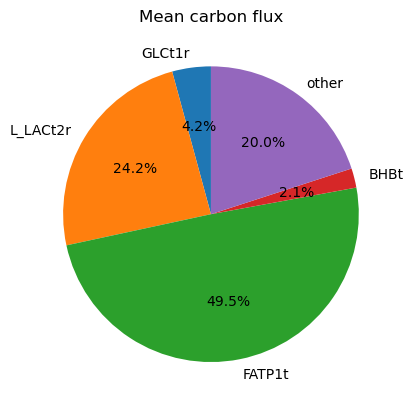

In [ ]:
# Change font size to 16 
#plt.rcParams.update({'font.size': 16})

# Scale scale the uptake fluxes by the number of carbons
mean_fluxes = load_fluxes( tfa_samples.mean(), tmodel, kmodel,
                            density=DENSITY,
                            ratio_gdw_gww=GDW_GWW_RATIO,
                            concentration_scaling=1.,
                            time_scaling=TIME_SCALING)[rows].abs()

carbons = pd.Series({ 'GLCt1r': 6, 'L_LACt2r': 3, 'FATP1t': 16, 'BHBt': 4, 'cyt_atp2adp': 0})[rows]

mean_carbon_flux = mean_fluxes * carbons

# Add a column that accounts for 20% of the total flux and label it as 'other'
mean_carbon_flux['other'] = mean_carbon_flux.sum() * (1/0.80 - 1)

# Drop the cytosolic ATP/ADP exchange
mean_carbon_flux = mean_carbon_flux.drop('cyt_atp2adp', axis=0)

# A pie chart shoeing the distribution of the mean carbon flux:
fig, ax = plt.subplots()
mean_carbon_flux.plot.pie(ax=ax, subplots=True, figsize=(5,5), autopct='%1.1f%%', startangle=90)
plt.ylabel('')
ax.set_title('Mean carbon flux')

plt.show()

In [ ]:
carbons = pd.Series({ 'GLCt1r': 6, 'L_LACt2r': 3, 'FATP1t': 16, 'BHBt': 4, 'cyt_atp2adp': 1})[rows]

mean_flux_control_corr = mean_flux_control#.multiply(mean_fluxes, axis=0).multiply(carbons, axis=0)
mean_flux_control_corr.head()

,ACACT1rm,ACONTm,ADK1,AKGDm,BDHm,BHBt,BHBtm,C160CPT1,C160CPT2,CO2t,...,r0509,r2435,bhb_e,co2_e,glc_D_e,h_e,hdca_e,lac_L_e,pi_c,o2_e
flux,,,,,,,,,,,,,,,,,,,,,
GLCt1r,-2.176099e-04,7.361524e-05,0.000084,0.007543,-5.773004e-04,-9.343852e-05,-5.910109e-06,-1.048105e-02,-5.619532e-05,2.140623e-04,...,2.395532e-05,-5.635365e-05,-4.213588e-04,-4.772515e-06,1.709582e-01,0.204277,-2.086722e-03,-0.034921,-0.019144,-0.076313
L_LACt2r,-3.166217e-02,1.994643e-03,-0.035948,0.198507,-4.285905e-02,-1.086447e-02,-6.095987e-04,-5.657936e-01,-3.156459e-03,6.997462e-03,...,-3.103158e-03,-3.186991e-03,-4.243668e-02,-1.574911e-04,-3.186274e-02,0.587789,-4.067676e-01,0.034251,0.054427,-0.574042
FATP1t,2.533845e-03,-7.741766e-04,0.013541,-0.069188,1.174612e-03,1.974118e-04,1.528550e-05,2.164809e-01,1.200560e-03,-2.575891e-03,...,1.150368e-03,1.211859e-03,1.127285e-03,5.853455e-05,1.002923e-04,-0.239222,1.517176e-01,-0.002243,-0.032959,0.228217
BHBt,2.167186e-01,2.746117e-04,-0.004265,-0.004990,4.435425e-01,1.105540e-01,5.887314e-03,-9.586414e-02,-5.557138e-04,-2.503650e-03,...,1.694905e-03,-5.626100e-04,4.616277e-01,5.734649e-05,-5.114802e-04,-0.122337,-3.849082e-02,-0.140025,-0.108153,0.130921
cyt_atp2adp,3.321196e-08,3.292237e-08,0.000003,0.000003,4.595192e-08,8.324810e-09,6.350521e-10,-6.687019e-07,-4.322872e-09,1.013781e-07,...,2.314625e-08,-4.320997e-09,4.590618e-08,-2.427668e-09,1.052165e-07,-0.000008,-3.339163e-07,0.000002,0.000062,0.000020


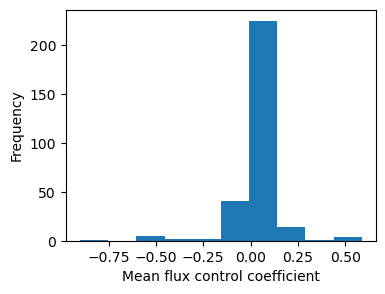

In [ ]:
f, ax = plt.subplots(figsize=(4, 3))
plt.hist(mean_flux_control_corr.values.flatten(), bins=10)
plt.xlabel('Mean flux control coefficient')
plt.ylabel('Frequency')
plt.show()



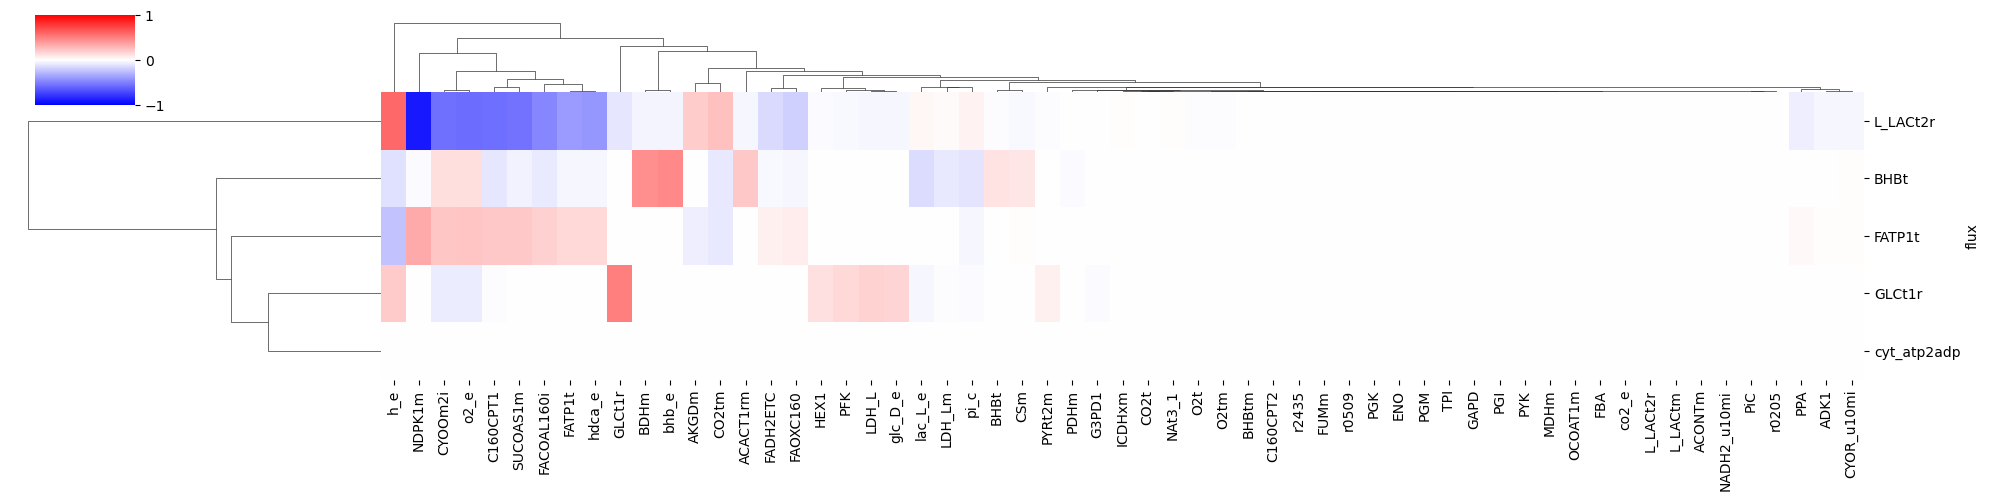

In [ ]:

# Plot a cluster map of the flux control coefficients
sns.clustermap(mean_flux_control_corr,row_cluster=True,col_cluster=True, cmap='bwr', center=0, figsize=(20,5), vmin=-1, vmax=1) 
# Change the xtick to have all colm

plt.show()

In [ ]:
# Get the parameter set that is closeset to the median flux control coefficients
median_control_coeffcienets = control_coefficients.quantile('samples', 0.5) 

distance_to_median = [((control_coefficients.slice_by('samples', i).loc[rows] - median_control_coeffcienets.loc[rows])**2).values.sum() for i in control_coefficients.indexes['samples']]

closest_to_median = control_coefficients.indexes['samples'][np.argmin(distance_to_median)]

print(f'Closest to median:{closest_to_median} with distance {np.min(distance_to_median)} (mean distance {np.mean(distance_to_median)})')


Closest to median:23,0 with distance 4.7658199156458165 (mean distance 34.856375993974375)


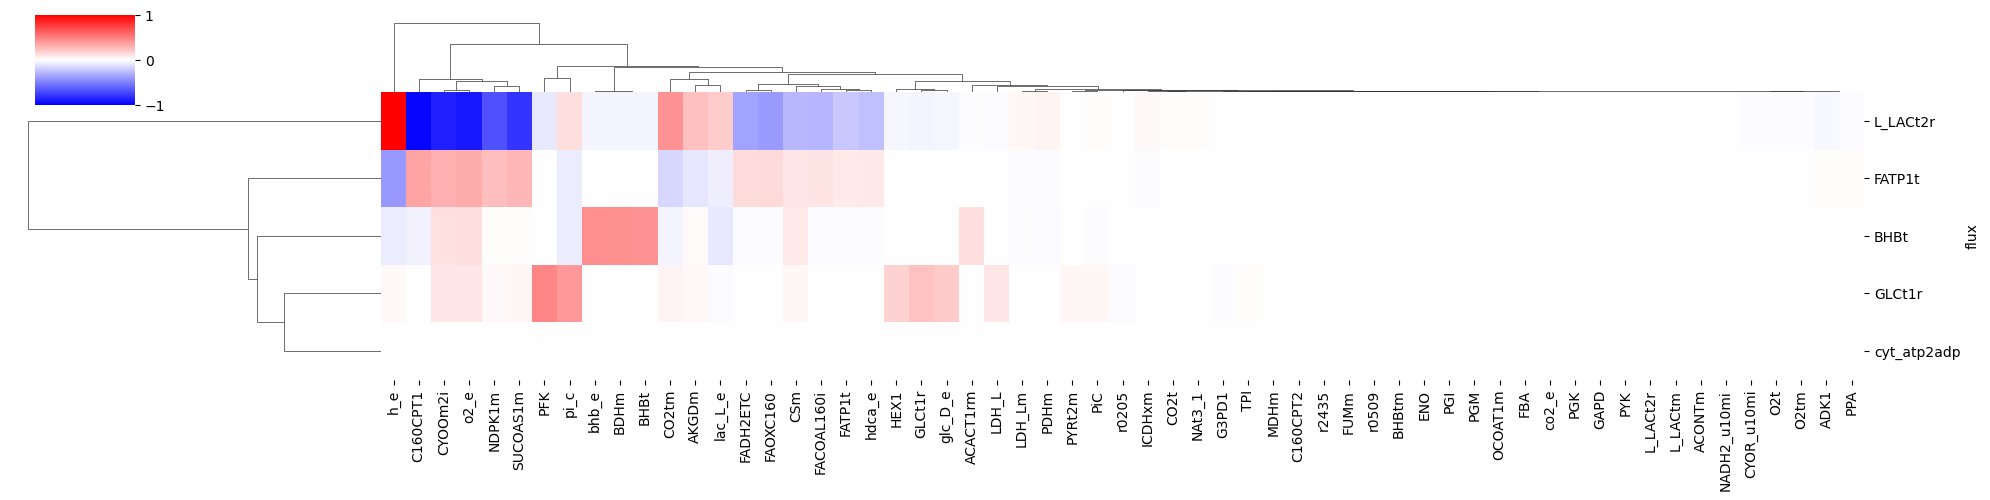

In [ ]:
CC = control_coefficients.slice_by('samples',closest_to_median)
CC.columns = [i.replace("vmax_forward_", '') for i in CC.columns ]
# Plot a cluster map of the flux control coefficients
sns.clustermap(CC.loc[rows,colums],row_cluster=True,col_cluster=True, cmap='bwr', center=0, figsize=(20,5), vmin=-1.0, vmax=1.0)    
# Change the xtick to have all colm

plt.show()

In [ ]:
# Compile ODEs 
kmodel.compile_ode(ncpu=NCPU)

In [ ]:
thermo_index = int(closest_to_median.split(',')[0])
thermo_sample = tfa_samples.loc[thermo_index]

concentrations = load_concentrations(thermo_sample, tmodel, kmodel, 
                                     concentration_scaling=CONCENTRATION_SCALING)

for k in kmodel.initial_conditions:
        kmodel.initial_conditions[k] = concentrations[k]


In [ ]:
# # Test steady state
# sol = kmodel.solve_ode(np.linspace(0, 10, 1000), solver_type='cvode')
# #sol.concentrations.plot()


In [ ]:
# Compute fluxes as a function of time 
from skimpy.analysis.ode.utils import make_flux_fun
from skimpy.utils.namespace import QSSA

flux_fun = make_flux_fun(kmodel, QSSA)

In [ ]:
from skimpy.core.parameters import ParameterValues

# Compute a curve that captures the sensitivty of fasted fatty acids concentration to beta oxidation
ref_ffa = parameter_population[closest_to_median]['hdca_e']

ffa_conc = np.linspace(0.1, 2, 50) * ref_ffa

uptakes = ['GLCt1r', 'L_LACt2r', 'FATP1t', 'BHBt','cyt_atp2adp']

kmodel.parameters = parameter_population[closest_to_median]

steady_state_fluxes = []

for ffa in ffa_conc:
    kmodel.parameters['hdca_e'].value = ffa
    sol = kmodel.solve_ode(np.linspace(0, 10, 100), solver_type='cvode')
    # save the uptake fluxes
    parameter_values = {p.symbol:p.value for p in kmodel.parameters.values()}
    parameter_values = ParameterValues(parameter_values, kmodel)
    this_fluxes = pd.Series(flux_fun(sol.concentrations.iloc[-1], parameters=parameter_values), index=kmodel.reactions.keys())
    this_fluxes = this_fluxes.loc[uptakes]

    steady_state_fluxes.append(this_fluxes)

steady_state_fluxes = pd.concat(steady_state_fluxes, axis=1).T


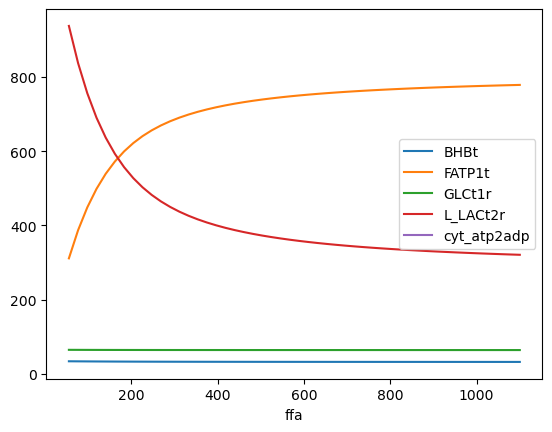

In [ ]:
uptake_fluxes = steady_state_fluxes.abs()[['GLCt1r', 'L_LACt2r', 'FATP1t', 'BHBt']].multiply(carbons, axis=1)
uptake_fluxes['ffa'] = ffa_conc * 1e3

# Plot the uptake fluxes as a function of the fatty acid concentration
f, ax = plt.subplots()
uptake_fluxes.plot(x='ffa', ax=ax)

plt.show()

In [ ]:
# Compute a fed state perturbation 
kmodel.parameters = parameter_population[closest_to_median]

# Concentrations 
kmodel.parameters['glc_D_e'].value = 7.5    # concentration in mM
kmodel.parameters['lac_L_e'].value = 1.0    # concentration in mM Guess
kmodel.parameters['hdca_e'].value = 0.2  # concentration in mM
kmodel.parameters['bhb_e'].value = 0.1    # concentration in mM

# Insulin effect on glucose transport
kmodel.parameters['vmax_forward_GLCt1r'].value = parameter_population[closest_to_median]['vmax_forward_GLCt1r'] * 5.0

kmodel.parameters['vmax_forward_PFK'].value = parameter_population[closest_to_median]['vmax_forward_PFK'] * 5.0
kmodel.parameters['vmax_forward_HEX1'].value = parameter_population[closest_to_median]['vmax_forward_HEX1'] * 5.0


kmodel.parameters['vmax_forward_PGI'].value = parameter_population[closest_to_median]['vmax_forward_PGI'] * 5.0 
kmodel.parameters['vmax_forward_LDH_L'].value = parameter_population[closest_to_median]['vmax_forward_LDH_L'] * 5.0


# Insulin inhibit carnitie transpharse by acting on ACC promoting Malonyl-CoA production
# kmodel.parameters['vmax_forward_C160CPT1'].value = parameter_population[closest_to_median]['vmax_forward_C160CPT1'] * 0.8

# G3P shuttle
kmodel.parameters['vmax_forward_G3PD1'].value = parameter_population[closest_to_median]['vmax_forward_G3PD1'] * 1.0
kmodel.parameters['vmax_forward_r0205'].value = parameter_population[closest_to_median]['vmax_forward_r0205'] * 1.0



In [ ]:
# Explore regulation of what is likely to regulate energy demand by looking most sensitive metabolties to reduction of ATP demand
kmodel.parameters = parameter_population[closest_to_median]

# Change cyt_atp2adp incrase 2 fold  // this does not work
kmodel.parameters['vmax_forward_cyt_atp2adp'].value = parameter_population[closest_to_median]['vmax_forward_cyt_atp2adp'] * 0.1




In [ ]:
# Note on VO2 max
# Ballpark could be arround 7x

In [ ]:
# # This is pretty confusing 

# from skimpy.core.parameters import ParameterValues

# hdca_titration = np.linspace(0.1, 1.0, 100)
# atp_flux = []
# uptake = [ ]
# for hdca in hdca_titration:
#     kmodel.parameters['hdca_e'].value = hdca
#     sol = kmodel.solve_ode(np.linspace(0, 10, 1000), solver_type='cvode')

#     parameter_values = {p.symbol:p.value for p in kmodel.parameters.values()}
#     parameter_values = ParameterValues(parameter_values, kmodel)

#     fluxes = flux_fun(sol.concentrations.iloc[-1],parameters=parameter_values)

#     atp_flux.append(fluxes['cyt_atp2adp'])
#     uptake.append(fluxes['FATP1t'])

# plt.plot(hdca_titration, atp_flux)
# plt.xlabel('HDCA concentration [mM]')
# plt.ylabel('ATP flux [mM/min]')

In [ ]:
# Solve the ODE system
time = np.logspace(-3,2, 100)
sol = kmodel.solve_ode(time,solver_type='cvode')

In [ ]:
from skimpy.core.parameters import ParameterValues
parameter_values = {p.symbol:p.value for p in kmodel.parameters.values()}
parameter_values = ParameterValues(parameter_values, kmodel)

fluxes = pd.Series( flux_fun(concentrations=concentrations, parameters=parameter_population[closest_to_median]), index=kmodel.reactions.keys())

sol_fluxes = pd.DataFrame( [ flux_fun(sol.concentrations.loc[i], parameters=parameter_values) for i in  sol.concentrations.index] , index=sol.concentrations.index, columns=kmodel.reactions.keys())


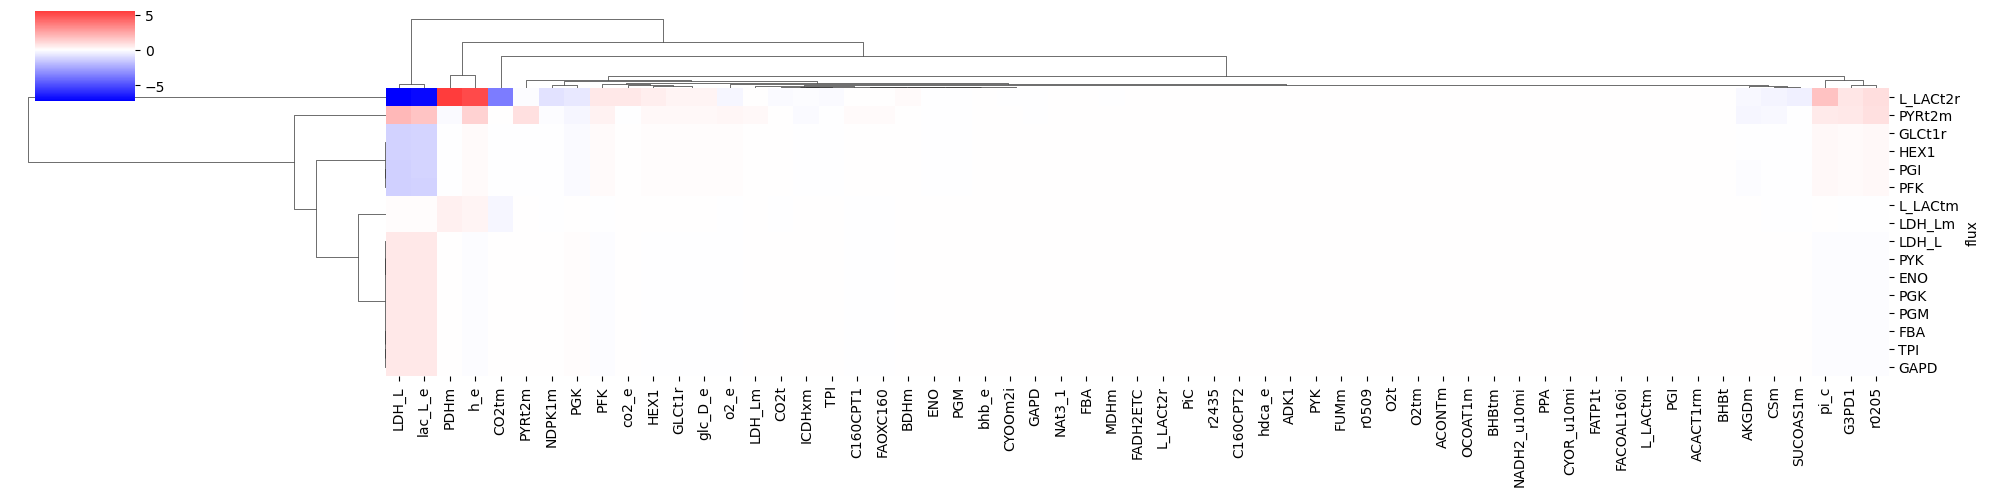

In [ ]:
glucose_resp = [ 'GLCt1r','HEX1', 'PGI', 'PFK', 'FBA', 'TPI', 'GAPD', 'PGK', 'PGM', 'ENO', 'PYK', 'PYRt2m', 'LDH_L',]
lactate_resp = [ 'L_LACt2r','L_LACtm', 'LDH_Lm', ]

lac_glu_rows = glucose_resp + lactate_resp
# Control coefficients in the new steady state
test_fc = kmodel.flux_control_fun(sol_fluxes.iloc[-1],sol.concentrations.iloc[-1],[parameter_values, ]).slice_by('sample', 0)
test_fc.columns = [i.replace("vmax_forward_", '') for i in test_fc.columns ]
sns.clustermap(test_fc.loc[lac_glu_rows,colums], row_cluster=True, col_cluster=True, cmap='bwr', center=0, figsize=(20,5))

In [ ]:
# # Control coefficients in the new steady state
# test_cc = kmodel.concentration_control_fun(sol_fluxes.iloc[-1],sol.concentrations.iloc[-1],[parameter_values, ]).slice_by('sample', 0)
# sns.clustermap(test_cc, row_cluster=True, col_cluster=True, cmap='bwr', center=0, figsize=(20,20), vmin=-1, vmax=1)    

/opt/homebrew/Caskroom/miniconda/base/envs/skimpy-env/lib/python3.8/site-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: invalid value encountered in log2
  result = func(self.values, **kwargs)


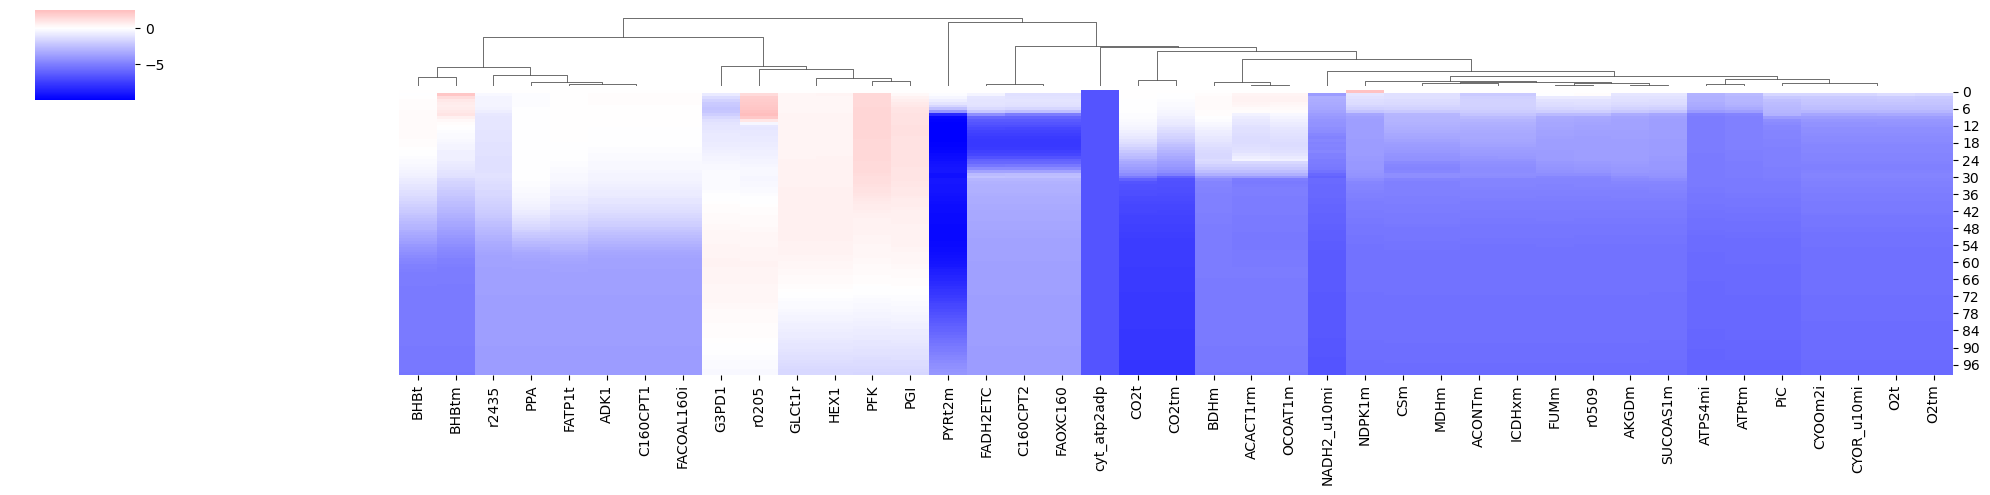

In [ ]:
# Convert the time series concentration in to a logic series of which elements start rising and which start falling in which order
fluxes_fold_change = np.log2(sol_fluxes.div(fluxes, axis=1))
fluxes_fold_change = fluxes_fold_change.dropna(axis=1)

# Make a cluster map 
sns.clustermap(fluxes_fold_change, row_cluster=False, col_cluster=True, cmap='bwr', center=0, figsize=(20,5))
plt.show()

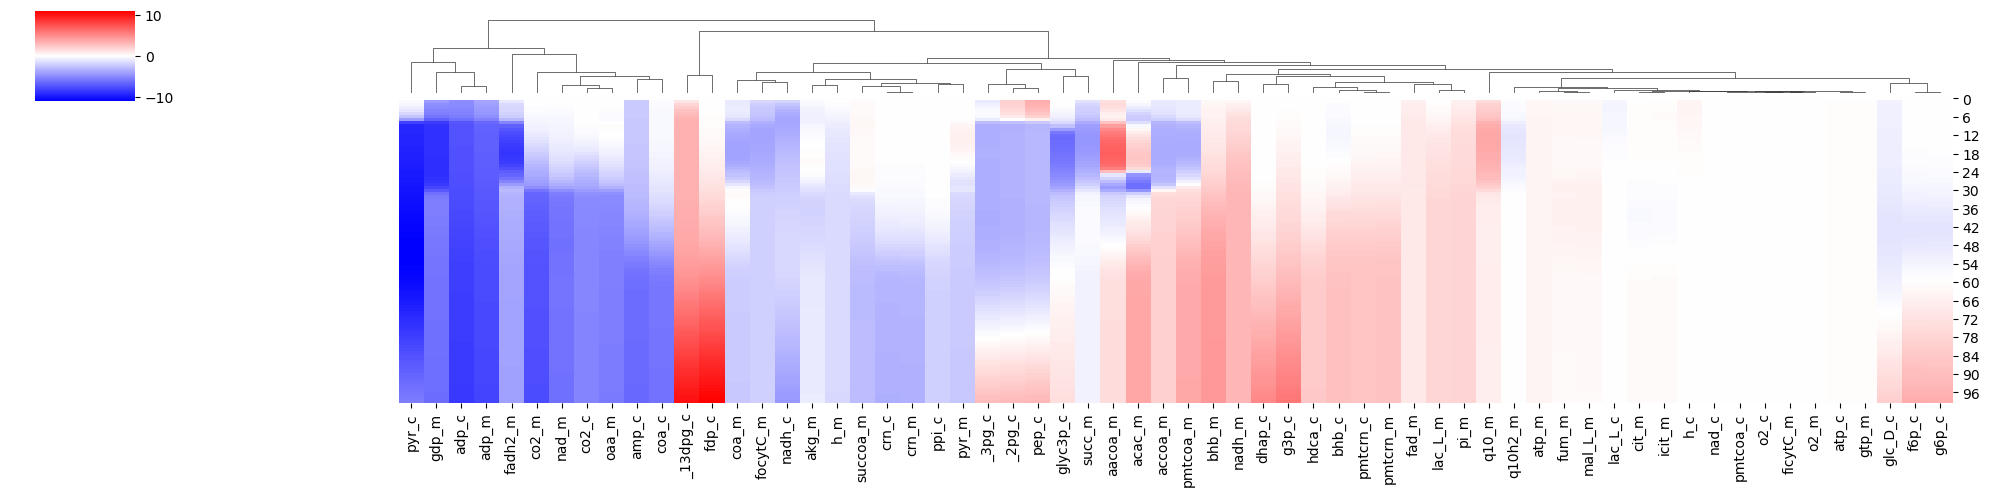

In [ ]:
# Convert the time series concen
concentrations_fold_change = np.log2(sol.concentrations.div(concentrations, axis=1))
concentrations_fold_change = concentrations_fold_change.dropna(axis=1)

# Make a cluster map 
sns.clustermap(concentrations_fold_change, row_cluster=False, col_cluster=True, cmap='bwr', center=0, figsize=(20,5))
plt.show()

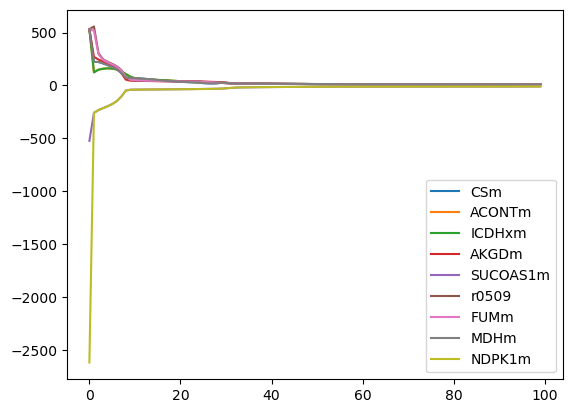

In [ ]:
# Observe the TCA cycle intermediates
tca_cycle = ['CSm' , 'ACONTm', 'ICDHxm', 'AKGDm', 'SUCOAS1m', 'r0509', 'FUMm', 'MDHm','NDPK1m']
etc = ['CYOR_u10mi', 'FADH2ETC', 'NADH2_u10mi', 'ATPS4mi', 'FADH2ETC']

sol_fluxes[tca_cycle].plot()

# Print vmax_forward values
tca_vmax = pd.Series({k: parameter_population[closest_to_median]['vmax_forward_'+k] for k in tca_cycle}) 
etc_vmax = pd.Series({k: parameter_population[closest_to_median]['vmax_forward_'+k] for k in etc})

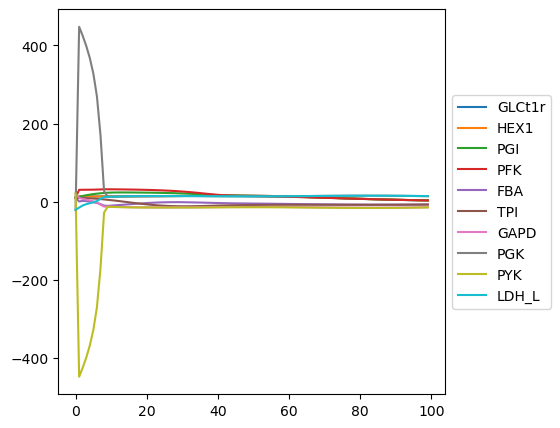

In [ ]:
# select some reactions
glycolysis = [ 'GLCt1r','HEX1', 'PGI', 'PFK', 'FBA', 'TPI', 'GAPD', 'PGK',  'PYK', 'LDH_L',]
uptakes = ['GLCt1r', 'L_LACt2r', 'FATP1t', 'BHBt','HEX1']

lactate = ['L_LACt2r','L_LACtm', 'LDH_L','LDH_Lm','PDHm']

fatty_acid = ['FATP1t', 'C160CPT1', 'FACOAL160i']

# print glycolysis vmax_forward parameters
glycolysis_vmax = pd.Series({k: parameter_population[closest_to_median]['vmax_forward_'+k] for k in glycolysis}) 
lacate_vmax = pd.Series({k: parameter_population[closest_to_median]['vmax_forward_'+k] for k in lactate})
fatty_acid_vmax = pd.Series({k: parameter_population[closest_to_median]['vmax_forward_'+k] for k in fatty_acid})


# Plot the time series of the fluxes
sol_fluxes[glycolysis].plot(figsize=(5,5))
# put legend outside the plot
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    


Text(0, 0.5, '')

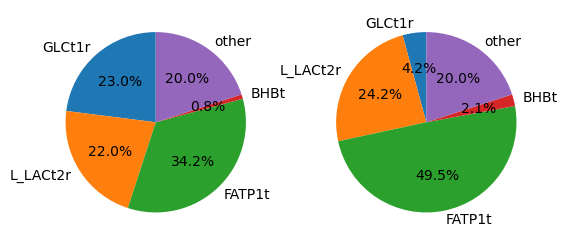

In [ ]:
# ANOTHER STORY

# To test how close to zero the dxdt is
flux_scaling_factor = 1e-3 / (GDW_GWW_RATIO / DENSITY) \
                        * CONCENTRATION_SCALING \
                        / TIME_SCALING

fluxes_profiles = pd.read_csv('reduced_model_ETC_core_20240710-100629_char_flux_profiles.csv', index_col=0)
# Convert from tfa to kintic flux spapce 
fluxes_profiles = fluxes_profiles * flux_scaling_factor

reaction_ix = list(kmodel.reactions.keys())


# Compute the mean carbon flux from fed fed state predition 
mean_carbon_flux_fed = fluxes_profiles.loc[:,'fed'].loc[rows].abs() * carbons

# Drop the cytosolic ATP/ADP exchange
mean_carbon_flux_fed = mean_carbon_flux_fed.drop('cyt_atp2adp', axis=0)

# Add a column that accounts for 25% of the total flux and label it as 'other'
mean_carbon_flux_fed['other'] = mean_carbon_flux_fed.sum() * (1/0.80 - 1)


# A pie chart shoeing the distribution of the mean carbon flux:
fig, ax = plt.subplots(1,2)
mean_carbon_flux_fed.plot.pie(ax=ax[0], subplots=True, figsize=(5,5), autopct='%1.1f%%', startangle=90)
mean_carbon_flux.plot.pie(ax=ax[1], subplots=True, figsize=(5,5), autopct='%1.1f%%', startangle=90)
plt.ylabel('')


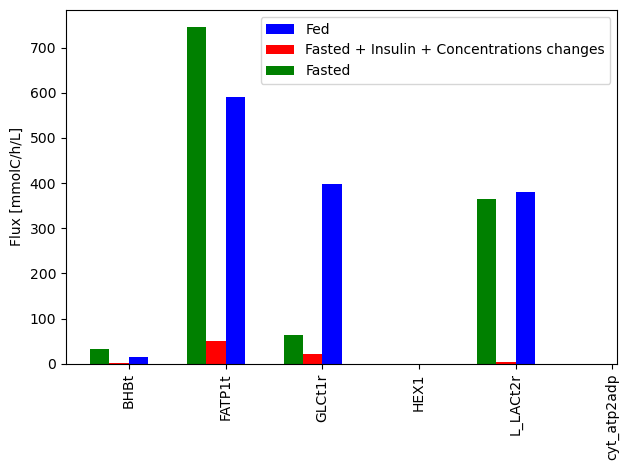

In [ ]:
# Compare uptake fluxes between simulated and inferred

# Plot target and predicted fluxes as stacked bars next to each other
fig, ax = plt.subplots(1,1)

target_fluxes = fluxes_profiles.loc[uptakes,'fed'].multiply(carbons, axis=0)
predicted_fluxes = sol_fluxes[uptakes].iloc[-1].multiply(carbons, axis=0)
original_fluxes = fluxes_profiles.loc[uptakes,'fasted'].multiply(carbons, axis=0)

target_fluxes.abs().plot(kind='bar', ax=ax, color='b', position=0, width=0.2, label='Fed')
predicted_fluxes.abs().plot(kind='bar', ax=ax, color='r', position=1, width=0.2, label='Fasted + Insulin + Concentrations changes')
original_fluxes.abs().plot(kind='bar', ax=ax, color='g', position=2, width=0.2, label='Fasted')

plt.ylabel('Flux [mmolC/h/L]')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# In